# Assignment 1
Gruppe 2: Albrecht Oster, Linus Helfmann

## Exercise 1.1

rough sketch for ex 1.2:

1. define the „positive“ subspace P in the RGB cube
2. iterate over all pixels in I and check if in P or ~P
3. write result to new image
4. play around with size and shape of P and display binary image (**RESULT**)



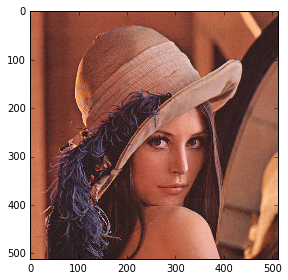

In [1]:
%matplotlib inline 
from skimage import io, data, color
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

image = io.imread('images/lena.png')
io.imshow(image)

In [2]:
# Hilfsfunktionen

def subspace(colorspace, delta, color):
    return all([abs(color[i]-colorspace[i]) <= delta for i in [0,1,2]])

def inBounds(image, x, y):
    if x >= 0 and x < image.shape[0] and y >= 0 and y < image.shape[1]:
        return True
    return False
        
def setWhite(image, x, y):
    if inBounds(image, x, y):
        image[x,y] = 1
    
def setBlack(image, x, y):
    if inBounds(image, x, y):
        image[x,y] = 0
        
def getWhite(image, x, y, default=False):
    if inBounds(image, x, y):
        return image[x,y]
    else:
        return default
    
def getNeighbours(image, x, y):
    return [(a,b) for (a,b) in [(x+1,y),(x,y+1),(x-1,y),(x,y-1)] \
                                if inBounds(image,a,b)]
    
def getNeighbourValues(image, x, y):
    return [getWhite(image,a,b) for a,b in getNeighbours(image,x,y)]

def setNeighboursWhite(image, x, y):
    [setWhite(image,a,b) for a,b in getNeighbours(image,x,y)]

In [3]:
def filterColor(image, color, delta=40, draw=False):
    new_image = np.zeros(image.shape[0:2])

    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if (subspace(color,delta,image[x,y])):
                setWhite(new_image,x,y)
    if draw:
        io.imshow(new_image)
    return new_image

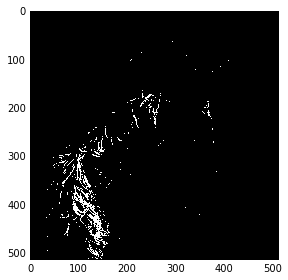

In [4]:
imageFilterd = filterColor(image, [80,80,120], 40, True)

## Exercise 1.2

* starting from the binary color detection image
* erase noise with an erosion operation
* dilate once to get original size of object
* find connected components with one-pass algorithm
* extract bounding box on the fly
* draw bounding box on original image (**RESULT**)

In [5]:
def erosion(image, draw=False):
    new_image = np.zeros(image.shape)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if (sum(getNeighbourValues(image,x,y)) > 2):
                setWhite(new_image,x,y);
    if draw:
        io.imshow(new_image)
    return new_image

In [6]:
def dilate(image, draw=False):
    new_image = np.zeros(image.shape)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if getWhite(image,x,y):
                setNeighboursWhite(new_image,x,y);
    if draw:
        io.imshow(new_image)
    return new_image

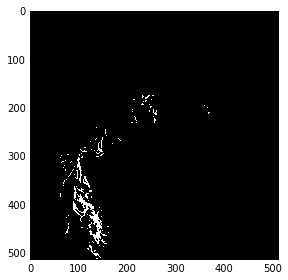

In [7]:
imageErosion = erosion(imageFilterd, True)

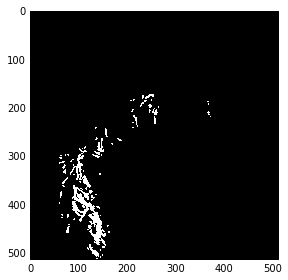

In [8]:
imageDilate = dilate(imageErosion, True)

In [9]:
class BoundingBox:
    def __init__(self, x,y):
        self.points = {(x,y)}
        self.xmin = x
        self.xmax = x
        self.ymin = y
        self.ymax = y
    
    def isNeighbour(self, image, x,y):
        if x+1 >= self.xmin and x-1 <= self.xmax and y+1 >= self.ymin and \
                                                        y-1 <= self.ymax:
            if any([(a,b) in self.points for (a,b) in getNeighbours(image,x,y)]):
                return True
        return False
    
    def add(self, x, y):
        self.points.add((x,y))
        self.xmin = min(x,self.xmin)
        self.xmax = max(x,self.xmax)
        self.ymin = min(y,self.ymin)
        self.ymax = max(y,self.ymax)
        
    def merge(self, other):
        self.points.update(other.points)
        self.xmin = min(other.xmin,self.xmin)
        self.xmax = max(other.xmax,self.xmax)
        self.ymin = min(other.ymin,self.ymin)
        self.ymax = max(other.ymax,self.ymax)
    
    def area(self):
        return (self.ymax-self.ymin) * (self.xmax - self.xmin)

In [10]:
def findBoxes(image):
    boxes = []

    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if getWhite(image, x, y):
                foundboxes = [box for box in boxes if box.isNeighbour(image,x,y)]
                if (len(foundboxes) == 0):
                    newbox = BoundingBox(x,y)
                    boxes.append(newbox)
                else:
                    box = foundboxes.pop()
                    while (len(foundboxes) > 0):
                        oldbox = foundboxes.pop()
                        boxes.remove(oldbox)
                        box.merge(oldbox)
                    box.add(x,y)
    return boxes

In [11]:
def drawBoxes(image, boxes):
    fig, ax = plt.subplots(1)

    ax.imshow(image)

    for box in boxes:
        rect = patches.Rectangle((box.ymin, box.xmin), box.ymax-box.ymin, \
                    box.xmax-box.xmin, linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

    plt.show()

def drawLine(image, boxes):
    fig, ax = plt.subplots(1)

    ax.imshow(image)

    verts = []
    codes = []
    for box in boxes:
        codes.append(patches.Path.LINETO)
        verts.append(((box.ymax+box.ymin)/2.0,(box.xmax+box.xmin)/2.0))

    codes[0] = patches.Path.MOVETO
    path = patches.Path(verts, codes)
    patch = patches.PathPatch(path,linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(patch)

    plt.show()

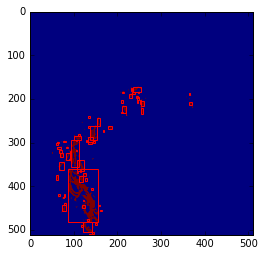

Boxen: 480 Pixel: 5535


In [12]:
boxes = findBoxes(imageDilate)
drawBoxes(imageDilate, boxes)
print("Boxen:",len(boxes),"Pixel:",sum([len(box.points) for box in boxes]))

## Exercise 1.3

* use your color detection and connected components algorithm
* implement simplest tracking algorithm
* draw history of all previous points on frame (**RESULT**)

(see images/racecar or images/taco for sample image sequences)

In [13]:
import os

path = 'images/taco/'
images = []
for file in sorted([path + f for f in os.listdir(path)]):
    images.append(io.imread(file))

In [14]:
def selectBiggestBox(boxes):
    maxArea = 0
    biggestBox = []
    for box in boxes:
        if (box.area() > maxArea):
            maxArea = box.area()
            biggestBox = [box]
    return biggestBox

def getBiggestBoxOfImage(image, color=[235,100,20]):
    image = filterColor(image, color)
    image = erosion(image)
    image = dilate(image)
    boxes = findBoxes(image)
    return selectBiggestBox(boxes)

In [15]:
# Alle Boxen berechnen
from multiprocessing import Pool as ThreadPool 
pool = ThreadPool(4)
boxes = pool.map(getBiggestBoxOfImage, images)
boxes = [b[0] for b in boxes]

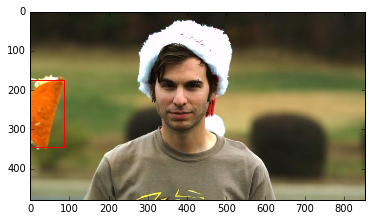

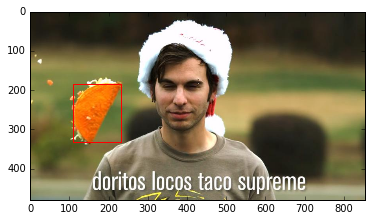

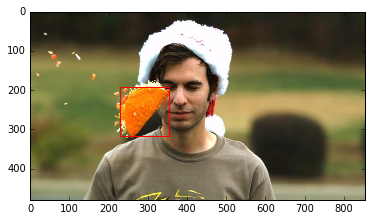

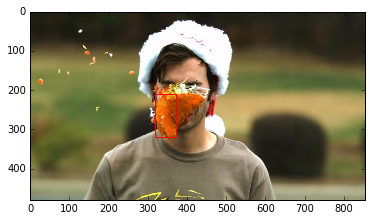

In [20]:
# jede 20. BoundingBox
for i in range(0,len(images),60):          
    drawBoxes(images[i], boxes[i:i+1])

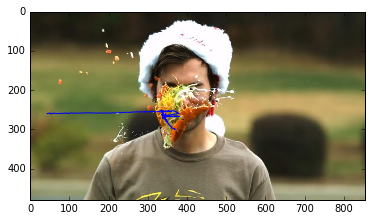

In [19]:
# Linie durch die Mittelpunkte aller BoundingBoxes
drawLine(images[-1], boxes)